In [1]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks
from scipy.stats import binom_test
import imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Example graph 

In [91]:
n=100
nr=75
sizes=[]
for seed in range(100):
    np.random.seed(seed)
    eta,nu,k,G=rmtchem.get_network(n,nr)
    adj=np.zeros((n,n))
    for r in range(2*nr):
        reac=np.where(eta[r]>0)[0]
        prod=np.where(nu[r]>0)[0]
        for i in reac:
            for j in prod:
                adj[i,j]=1
            #if species are both reactants, they affect rates of change of each other
            for j in reac:
                adj[i,j]=1
    g=nx.convert_matrix.from_numpy_matrix(adj)
    components=[list(component) for component in nx.connected_components(g)]
    sizes=sizes+[np.count_nonzero([len(component)-1 for component in components])]
    
np.where(np.array(sizes)>1)

(array([99]),)

84


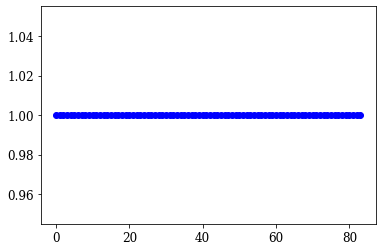

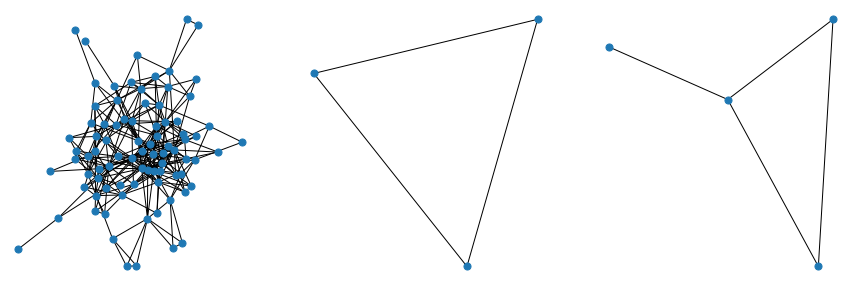

In [110]:
n=100
nr=50
seed=99

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
adj=np.zeros((n,n))
for r in range(2*nr):
    reac=np.where(eta[r]>0)[0]
    prod=np.where(nu[r]>0)[0]
    for i in reac:
        for j in prod:
            adj[i,j]=1
        #if species are both reactants, they affect rates of change of each other
        for j in reac:
            adj[i,j]=1
g=nx.convert_matrix.from_numpy_matrix(adj)

lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

print(n)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
success,Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2)
plt.plot(Xs2/X0,'bo')
plt.show()

g=nx.convert_matrix.from_numpy_matrix(adj)
components=list(sorted(nx.connected_components(g)))
nonempty=np.where(np.array([len(components[i]) for i in range(len(components))])>1)[0]
if len(components)>1:
    fig, ax = plt.subplots(1,len(nonempty),figsize=(5*len(nonempty),5))
    for i,j in enumerate(nonempty):
        comp=components[j]
        idx=np.array(list(comp))
        nx.draw(nx.convert_matrix.from_numpy_matrix(adj[np.ix_(idx,idx)]),node_size=50,ax=ax[i])
        ax[i].axis('off')
else:
    nx.draw(g,node_size=12.5,width=0.1)

plt.savefig('plots/fig1b.pdf')
plt.show()

In [102]:
0.075*np.log(100)

0.34538776394910686

In [106]:
n=100
nr=int(0.2*np.log(n)*n)
sizes=[]
for seed in range(100):
    np.random.seed(seed)
    eta,nu,k,G=rmtchem.get_network(n,nr)
    adj=np.zeros((n,n))
    for r in range(2*nr):
        reac=np.where(eta[r]>0)[0]
        prod=np.where(nu[r]>0)[0]
        for i in reac:
            for j in prod:
                adj[i,j]=1
            #if species are both reactants, they affect rates of change of each other
            for j in reac:
                adj[i,j]=1
    g=nx.convert_matrix.from_numpy_matrix(adj)
    components=[list(component) for component in nx.connected_components(g)]
    sizes=sizes+[np.count_nonzero([len(component) for component in components])]
    
np.where(np.array(sizes)==1)

(array([12, 16, 32, 34, 49, 50, 56, 60, 65, 91]),)

100


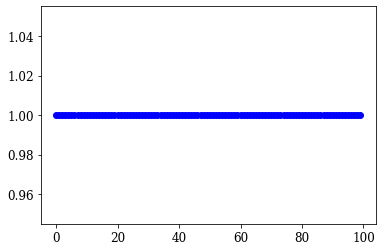

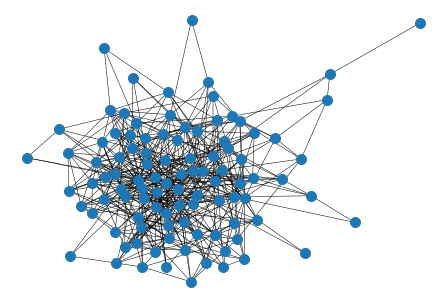

In [113]:
n=100
nr=int(0.2*np.log(n)*n)
seed=12

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
adj=np.zeros((n,n))
for r in range(2*nr):
    reac=np.where(eta[r]>0)[0]
    prod=np.where(nu[r]>0)[0]
    for i in reac:
        for j in prod:
            adj[i,j]=1
        #if species are both reactants, they affect rates of change of each other
        for j in reac:
            adj[i,j]=1
g=nx.convert_matrix.from_numpy_matrix(adj)

lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

print(n)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
success,Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2)
plt.plot(Xs2/X0,'bo')
plt.show()

g=nx.convert_matrix.from_numpy_matrix(adj)
components=list(sorted(nx.connected_components(g)))
nonempty=np.where(np.array([len(components[i]) for i in range(len(components))])>1)[0]
if len(components)>1:
    fig, ax = plt.subplots(1,len(nonempty),figsize=(5*len(nonempty),5))
    for i,j in enumerate(nonempty):
        comp=components[j]
        idx=np.array(list(comp))
        nx.draw(nx.convert_matrix.from_numpy_matrix(adj[np.ix_(idx,idx)]),node_size=50,ax=ax[i])
        ax[i].axis('off')
else:
    nx.draw(g,node_size=100,width=0.5)

plt.savefig('plots/fig1c.pdf')
plt.show()

### Chemical network percolation

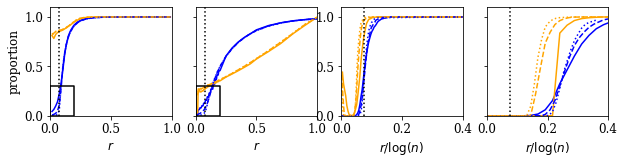

In [19]:
ns=[64,512,4096]
ls=['-','--',':']

plt.subplots(1,4,figsize=(10,2))

plt.subplot(1,4,1)
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.xlabel('$r$')

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3),dat[:,3],color='orange',linestyle=ls[i])
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(1,4,3)
plt.ylim(0,1.1)
plt.xlim(0,0.4)
plt.xlabel('$r/\log(n)$')
plt.ylabel("proportion")

# locs, labels = plt.yticks()
# plt.yticks(locs,[])
plt.ylim(0,1.1)

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(np.concatenate([dat[:,1]/(20/3)/np.log(n),[0.4]]), np.concatenate([dat[:,4],[1]]),color='blue',linestyle=ls[i])
    plt.plot(np.concatenate([dat[:,1]/(20/3)/np.log(n),[0.4]]), np.concatenate([dat[:,5],[1]]),color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(1,4,2)
plt.xlabel('$r$')
plt.ylim(0,1.1)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)
plt.xlim(0,1)
for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')

plt.subplot(1,4,4)
plt.xlabel('$r/\log(n)$')
plt.xlim(0,0.4)
plt.ylim(0,1.1)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.savefig('plots/fig2.pdf')
plt.show()

In [ ]:
ns=[64,512,4096]
ls=['-','--',':']

plt.subplots(2,2,figsize=(6,4))

plt.subplot(2,2,1)
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
locs, labels = plt.xticks()
plt.xticks(locs,[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3),dat[:,3],color='orange',linestyle=ls[i])
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,2)
plt.ylim(0,1.1)
plt.xlim(0,0.4)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

locs, labels = plt.xticks()
plt.xticks(locs,[])
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(np.concatenate([dat[:,1]/(20/3)/np.log(n),[0.4]]), np.concatenate([dat[:,4],[1]]),color='blue',linestyle=ls[i])
    plt.plot(np.concatenate([dat[:,1]/(20/3)/np.log(n),[0.4]]), np.concatenate([dat[:,5],[1]]),color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,3)
plt.xlabel('$c$')
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
    
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')

plt.subplot(2,2,4)
plt.xlabel('$c/\log(n)$')
plt.xlim(0,0.4)
plt.ylim(0,1.1)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.savefig('plots/fig2.pdf')
plt.show()

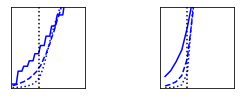

In [6]:
ns=[64,512,4096]
ls=['-','--',':']
fig, axs = plt.subplots(1,2,figsize=(4,1.5))

plt.subplot(1,2,1)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(1,2,2)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')
plt.subplots_adjust(wspace=1.0,hspace=0.0)

plt.savefig('plots/fig2insets.pdf')
plt.show()


### Bifurcation examples

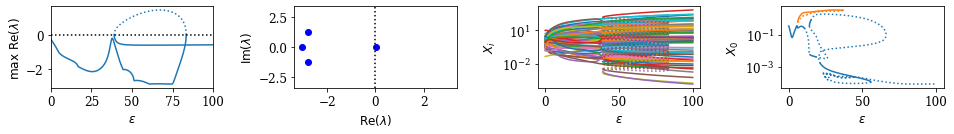

In [15]:
Xs=np.load('data/sn/Xs.npy')
evals=np.load('data/sn/evals.npy')
epsilons=np.load('data/sn/epsilons.npy')
Xts=np.load('data/sn/Xts.npy')
ts=np.load('data/sn/ts.npy')
n=len(Xts)

plt.subplots(1,4,figsize=(16,1.5))
plt.subplot(1,4,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
plt.xlim(0,100)
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.plot([0,100],[0,0],ls=':',color='black')

        
plt.subplot(1,4,2)
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
lim=1.1*np.max(np.abs(evals[m,np.argsort(np.real(evals[m]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[m]),np.imag(evals[m]),'bo')
plt.plot([0,0],[-lim,lim],ls=':',color='black')

plt.subplot(1,4,3)
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
plt.ylabel(r"$X_i$")
plt.xlabel('$\epsilon$')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
Xs0=np.load('data/chaos/Xs1.npy')
epsilons0=np.load('data/chaos/epsilons1.npy')
evals0=np.load('data/chaos/evals1.npy')
Xs2=np.load('data/chaos/Xs2.npy')
epsilons2=np.load('data/chaos/epsilons2.npy')
evals2=np.load('data/chaos/evals2.npy')
Xs3=np.load('data/chaos/Xs3.npy')
epsilons3=np.load('data/chaos/epsilons3.npy')
evals3=np.load('data/chaos/evals3.npy')

plt.subplot(1,4,4)
lst=[6]
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$X_0$')
inds1=np.where(np.max(np.real(evals0),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals0),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons0[inds],Xs0[inds,i],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons0[inds],Xs0[inds,i],ls=':',color=colors[0])

inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[1])

inds1=np.where(np.max(np.real(evals3),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals3),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],ls=':',color=colors[1])
        
plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3a.pdf')

plt.show()

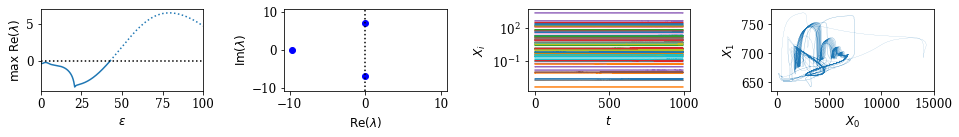

In [19]:
Xs=np.load('data/hopf/Xs.npy')
evals=np.load('data/hopf/evals.npy')
epsilons=np.load('data/hopf/epsilons.npy')
Xts=np.load('data/hopf/Xts.npy')
ts=np.load('data/hopf/ts.npy')
n=len(Xts)

plt.subplots(1,4,figsize=(16,1.5))
plt.subplot(1,4,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
plt.xlim(0,100)
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.plot([0,100],[0,0],ls=':',color='black')

plt.subplot(1,4,2)
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
lim=1.1*np.max(np.abs(evals[m,np.argsort(np.real(evals[m]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[m]),np.imag(evals[m]),'bo')
plt.plot([0,0],[-lim,lim],ls=':',color='black')


plt.subplot(1,4,3)
plt.yscale('log')
plt.ylabel('$X_i$')
plt.xlabel('$t$')
plt.plot(ts,np.transpose(Xts))

evals2=np.load('data/chaos/evals1.npy')
ts2=np.load('data/chaos/ts.npy')
Xts2=np.load('data/chaos/Xts.npy')
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
tmax=ts2[-1]


ax=plt.subplot(1,4,4)
ax.set_rasterization_zorder(0)
plt.xlabel(r'$X_0$')
plt.ylabel(r'$X_1$')
plt.plot(Xts2[0],Xts2[1],zorder=-1,linewidth=0.1,alpha=1.0)

plt.subplots_adjust(wspace=0.5,hspace=0.0)


plt.savefig('plots/fig3b.pdf',dpi=300)
plt.show()

### Bifurcations vs reactivity, catalyticity, and driving proportion

(54, 7)


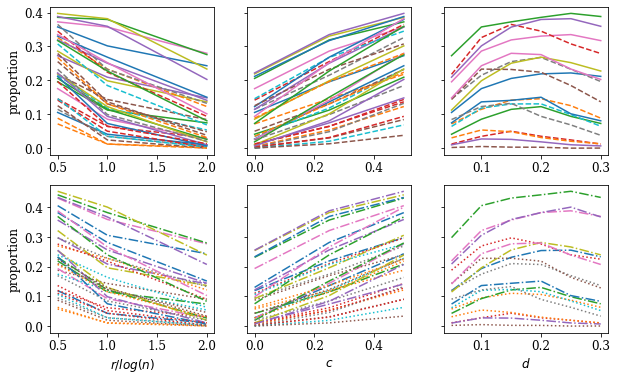

In [9]:
ns=[64]
cs=[0.5,1.0,2.0]
ds=[0.1, 0.2, 0.3]
ds=[0.05,0.1,0.15,0.2,0.25,0.3]
ass=[0,0.25,0.5]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]>=0)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==2)/tot, np.count_nonzero(vals[:,4]==1)/tot+np.count_nonzero(vals[:,4]==3)/tot, np.count_nonzero(vals[:,12]==0)/tot,  np.count_nonzero(vals[:,12]==1)/tot])
                
tab=np.array(tab)
print(tab.shape)
cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])

fig,ax=plt.subplots(2,3,figsize=(10,6))
plt.subplot(2,3,1)
# plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,3],ls='-')
        plt.plot(tab[ind,0],tab[ind,4],ls='--')

plt.subplot(2,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
# plt.xlabel('$c$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,3],ls='-')
        plt.plot(tab[ind,2],tab[ind,4],ls='--')

plt.subplot(2,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
# plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,3],ls='-')
        plt.plot(tab[ind,1],tab[ind,4],ls='--')
        
plt.subplot(2,3,4)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,5],ls='-.')
        plt.plot(tab[ind,0],tab[ind,6],ls=':')

plt.subplot(2,3,5)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$c$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,5],ls='-.')
        plt.plot(tab[ind,2],tab[ind,6],ls=':')

plt.subplot(2,3,6)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,5],ls='-.')
        plt.plot(tab[ind,1],tab[ind,6],ls=':')
        
        
        
plt.savefig('plots/fig4a.pdf',transparent=True)
plt.show()

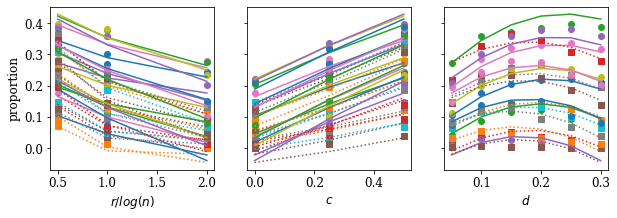

In [10]:
from scipy.optimize import curve_fit
def f(x,b0,b1,b2,b3,b4,b5,b6,b7, b8, b9):
    return b0+b1*x[0]+b2*x[1]+b3*x[2]+b4*x[1]**2+b5*x[0]*x[1]+b6*x[0]*x[2]+b7*x[1]*x[2]+b8*x[0]**2+b9*x[2]**2
ns=[64]
cs=[0.5,1.0,2.0]
ds=[0.1, 0.2, 0.3]
ds=[0.05,0.1,0.15,0.2,0.25,0.3]
ass=[0,0.25,0.5]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]>=0)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==2)/tot, np.count_nonzero(vals[:,4]==1)/tot+np.count_nonzero(vals[:,4]==3)/tot, np.count_nonzero(vals[:,12]==0)/tot,  np.count_nonzero(vals[:,12]==1)/tot])
                
tab=np.array(tab)
test1=curve_fit(f, np.transpose(tab[:,:3]), tab[:,3])
test2=curve_fit(f, np.transpose(tab[:,:3]), tab[:,4])
test3=curve_fit(f, np.transpose(tab[:,:3]), tab[:,5])
test4=curve_fit(f, np.transpose(tab[:,:3]), tab[:,6])

fig,ax=plt.subplots(1,3,figsize=(10,3))
plt.subplot(1,3,1)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.scatter(tab[ind,0],tab[ind,3])
        plt.plot(cs,[f([c,d,a],*test1[0]) for c in cs])
        plt.scatter(tab[ind,0],tab[ind,4],marker='s')
        plt.plot(cs,[f([c,d,a],*test2[0]) for c in cs],ls=':')

plt.subplot(1,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$c$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.scatter(tab[ind,2],tab[ind,3])
        plt.plot(ass,[f([c,d,a],*test1[0]) for a in ass])
        plt.scatter(tab[ind,2],tab[ind,4],marker='s')
        plt.plot(ass,[f([c,d,a],*test2[0]) for a in ass],ls=':')
        
plt.subplot(1,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.scatter(tab[ind,1],tab[ind,3])        
        plt.plot(ds,[f([c,d,a],*test1[0]) for d in ds])
        plt.scatter(tab[ind,1],tab[ind,4],marker='s')
        plt.plot(ds,[f([c,d,a],*test2[0]) for d in ds],ls=':')
        
plt.show()

(54, 7)


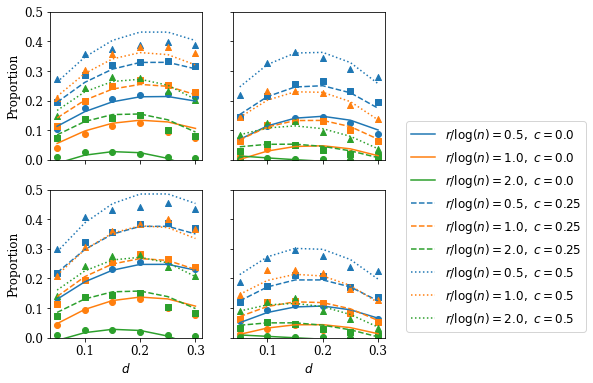

In [11]:
from scipy.optimize import curve_fit
def f(x,b0,b1,b2,b3,b4,b5,b6,b7, b8, b9,b10,b11):
    return b0+b1*x[0]+b2*x[1]+b3*x[2]+b4*x[1]**2+b5*x[0]*x[1]+b6*x[0]*x[2]+b7*x[1]*x[2]+b8*x[0]**2+b9*x[2]**2+b10*x[1]**2*x[0]+b11*x[1]**2*x[2]

ns=[64]
cs=[0.5,1.0,2.0]
ds=[0.1, 0.2, 0.3]
ds=[0.05,0.1,0.15,0.2,0.25,0.3]
ass=[0,0.25,0.5]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]>=0)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==2)/tot, np.count_nonzero(vals[:,4]==1)/tot+np.count_nonzero(vals[:,4]==3)/tot, np.count_nonzero(vals[:,12]==0)/tot,  np.count_nonzero(vals[:,12]==1)/tot])
            
            
tab=np.array(tab)
print(tab.shape)

test1=curve_fit(f, np.transpose(tab[:,:3]), tab[:,3])
test2=curve_fit(f, np.transpose(tab[:,:3]), tab[:,4])
test3=curve_fit(f, np.transpose(tab[:,:3]), tab[:,5])
test4=curve_fit(f, np.transpose(tab[:,:3]), tab[:,6])

cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])
ls=['-','--',':']
cls=['r','b','g']
ms=['o','s','^']

plt.subplots(2,2,figsize=(6,6))
plt.subplot(2,2,1)
plt.ylim(0,0.5)
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plt.ylabel('Proportion')
for i in range(len(ass)):
    for j in range(len(cs)):
        a=ass[i]
        c=cs[j]
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
#         plt.plot(tab[ind,1],tab[ind,3],ls=ls[i],color=colors[j])
        plt.plot(ds,[f([c,d,a],*test1[0]) for d in ds],ls=ls[i],color=colors[j])
        plt.scatter(tab[ind,1],tab[ind,3],color=colors[j],marker=ms[i])
    
plt.subplot(2,2,2)
plt.ylim(0,0.5)
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
for i in range(len(ass)):
    for j in range(len(cs)):
        a=ass[i]
        c=cs[j]
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
#         plt.plot(tab[ind,1],tab[ind,4],ls=ls[i],color=colors[j])
        plt.plot(ds,[f([c,d,a],*test2[0]) for d in ds],ls=ls[i],color=colors[j])
        plt.scatter(tab[ind,1],tab[ind,4],color=colors[j],marker=ms[i])
        
plt.subplot(2,2,3)
plt.ylim(0,0.5)
plt.ylabel('Proportion')
plt.xlabel('$d$')
for i in range(len(ass)):
    for j in range(len(cs)):
        a=ass[i]
        c=cs[j]
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
#         plt.plot(tab[ind,1],tab[ind,5],ls=ls[i],color=colors[j])
        plt.plot(ds,[f([c,d,a],*test3[0]) for d in ds],ls=ls[i],color=colors[j])
        plt.scatter(tab[ind,1],tab[ind,5],color=colors[j],marker=ms[i])
        
plt.subplot(2,2,4)
plt.ylim(0,0.5)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
labels=[]
for i in range(len(ass)):
    for j in range(len(cs)):
        a=ass[i]
        c=cs[j]
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
#         plt.plot(tab[ind,1],tab[ind,6],ls=ls[i],color=colors[j])
        plt.plot(ds,[f([c,d,a],*test4[0]) for d in ds],ls=ls[i],color=colors[j])
        plt.scatter(tab[ind,1],tab[ind,6],color=colors[j],marker=ms[i])
        labels.append(r"$r/\log(n)="+str(c)+",~c="+str(a)+"$")
        
plt.legend(labels,loc='lower left', bbox_to_anchor=(1.1, 0.0))

plt.savefig('plots/fig4a.pdf',transparent=True)
plt.show()

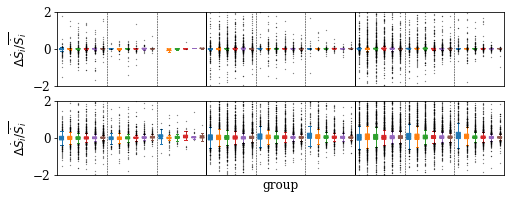

In [12]:
ns=[64]
cs=[0.5,1.0,2.0]
ds=[0.1,0.2,0.3]
ds=[0.05,0.1,0.15,0.2,0.25,0.3]
ass=[0,0.25,0.5]

fig,ax=plt.subplots(2,1,figsize=(8,3))
ax[0].set_rasterization_zorder(0)
ax[1].set_rasterization_zorder(0)
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plots1=[]
plots2=[]
plots3=[]
plots4=[]
for n in ns:
    for a in ass:
        for c in cs:
            for d in ds:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                inds1=np.intersect1d(np.intersect1d(np.where(vals[:,4]==3)[0],np.where(vals[:,12]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                inds2=np.intersect1d(np.intersect1d(np.where(vals[:,4]==2)[0],np.where(vals[:,12]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                plots1.append(2*(vals[inds1,7]-vals[inds1,6])/(vals[inds1,7]+vals[inds1,6]))
                plots2.append(2*(vals[inds2,7]-vals[inds2,6])/(vals[inds2,7]+vals[inds2,6]))
                plots3.append(2*(vals[inds1,7]-vals[inds1,6])/(vals[inds1,6]))
                plots4.append(2*(vals[inds2,7]-vals[inds2,6])/(vals[inds2,6]))
                
                
plt.subplot(2,1,1)
plt.xticks([])
plt.ylabel(r'$\Delta \dot{S}_i / \overline{\dot{S}_i}$')
box1=plt.boxplot(plots1,notch=True,patch_artist=True,showfliers=True,flierprops={'markersize':0.2,'zorder':-1},zorder=-10)
for item in ['boxes', 'fliers', 'medians']:
    for i in range(len(ds)):
        plt.setp(box1[item][i::len(ds)], color=colors[i])
for item in ['whiskers','caps']:
    for i in range(len(ds)):
        plt.setp(box1[item][2*i::2*len(ds)], color=colors[i])
        plt.setp(box1[item][2*i+1::2*len(ds)], color=colors[i])

plt.ylim(-2,2)
ymin=-2
ymax=2
for i in range(len(cs)*len(ass)):
    plt.plot([(i+1)*len(ds)+0.5,(i+1)*len(ds)+0.5],[ymin,ymax], ls='--', color='black', linewidth=0.5)
for i in range(len(ass)):
    plt.plot([(i+1)*len(ds)*len(cs)+0.5,(i+1)*len(ds)*len(cs)+0.5],[ymin,ymax],ls='-',color='black',linewidth=1)
plt.xticks([])


plt.subplot(2,1,2)
plt.xlabel('group')
plt.ylabel(r'$\Delta \dot{S}_i / \overline{\dot{S}_i}$')
# plt.yscale('symlog')
box1=plt.boxplot(plots2,notch=True,patch_artist=True,showfliers=True,flierprops={'markersize':0.2,'zorder':-1},zorder=-10)
for item in ['boxes', 'fliers', 'medians']:
    for i in range(len(ds)):
        plt.setp(box1[item][i::len(ds)], color=colors[i])
for item in ['whiskers','caps']:
    for i in range(len(ds)):
        plt.setp(box1[item][2*i::2*len(ds)], color=colors[i])
        plt.setp(box1[item][2*i+1::2*len(ds)], color=colors[i])

plt.ylim(-2,2)
ymin=-2
ymax=2
for i in range(len(cs)*len(ass)):
    plt.plot([(i+1)*len(ds)+0.5,(i+1)*len(ds)+0.5],[ymin,ymax], ls='--', color='black', linewidth=0.5)
for i in range(len(ass)):
    plt.plot([(i+1)*len(ds)*len(cs)+0.5,(i+1)*len(ds)*len(cs)+0.5],[ymin,ymax],ls='-',color='black',linewidth=1)
plt.xticks([])


plt.savefig('plots/fig4b.pdf',transparent=True,dpi=300)
plt.show()


0.841121392985387 0.5529939233937959 8.267307604748796e-110
0.6687484761967695 0.6800069450473132 0.0


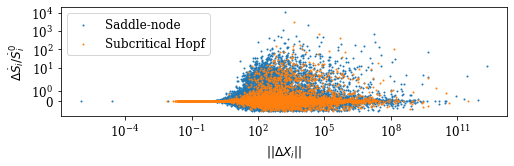

In [13]:
ns=[64]
cs=[2.0,1.0,0.5]
ds=[0.05,0.1,0.15,0.2,0.25,0.3]
ass=[0,0.25,0.5]
c1='blue'
c2='red'
c3='green'

fig=plt.figure(figsize=(8,2))

plots1=[]
plots2=[]
for n in ns:
    for a in ass:
        for c in cs:
            for d in ds:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                inds1=np.intersect1d(np.intersect1d(np.where(vals[:,4]==2)[0],np.where(vals[:,12]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                inds2=np.intersect1d(np.intersect1d(np.where(vals[:,4]==3)[0],np.where(vals[:,12]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                plots1.append(np.transpose([vals[inds1,10],(vals[inds1,7]-vals[inds1,6])/vals[inds1,6]]))
                plots2.append(np.transpose([vals[inds2,10],(vals[inds2,7]-vals[inds2,6])/vals[inds2,6]]))
                
plots1=np.concatenate(plots1)
plots2=np.concatenate(plots2)

ps=np.count_nonzero(plots1[:,1]>0)
ns=np.count_nonzero(plots1[:,1]<=0)
ph=np.count_nonzero(plots2[:,1]>0)
nh=np.count_nonzero(plots2[:,1]<=0)

print(np.mean(plots1[:,1]),ps/(ps+ns),binom_test([ps,ns],alternative='greater'))
print(np.mean(plots2[:,1]),ph/(ph+nh),binom_test([ph,nh],alternative='greater'))


plt.xscale('log')
plt.yscale('symlog')
plt.ylabel(r'$\Delta \dot{S}_i / \dot{S}_i^0$')
plt.xlabel(r'$|| \Delta X_i ||$')
plt.scatter(plots1[:,0],plots1[:,1],s=1,zorder=-1)
plt.scatter(plots2[:,0],plots2[:,1],s=1,zorder=-1)
fig.axes[0].set_rasterization_zorder(0)

plt.legend(['Saddle-node','Subcritical Hopf'])

plt.savefig('plots/fig4c.pdf',transparent=True,dpi=300)

plt.show()

0.02679794274175374 0.677719506005752 3.6725775160729822e-168
0.055152687092907916 0.5564904367437221 2.3339242815527767e-66


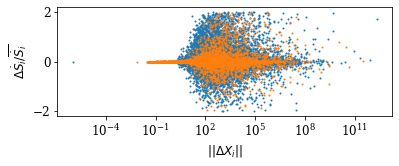

In [29]:
ns=[64]
cs=[2.0,1.0,0.5]
ds=[0.1,0.2,0.3]
ass=[0,0.25,0.5]
c1='blue'
c2='red'
c3='green'

fig=plt.figure(figsize=(6,2))

plots1=[]
plots2=[]
for n in ns:
    for a in ass:
        for c in cs:
            for d in ds:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                inds1=np.intersect1d(np.intersect1d(np.where(vals[:,4]==3)[0],np.where(vals[:,12]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                inds2=np.intersect1d(np.intersect1d(np.where(vals[:,4]==2)[0],np.where(vals[:,12]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                plots1.append(np.transpose([vals[inds1,10],2*(vals[inds1,7]-vals[inds1,6])/(vals[inds1,7]+vals[inds1,6])]))
                plots2.append(np.transpose([vals[inds2,10],2*(vals[inds2,7]-vals[inds2,6])/(vals[inds2,7]+vals[inds2,6])]))
                
plots1=np.concatenate(plots1)
plots2=np.concatenate(plots2)

ps=np.count_nonzero(plots1[:,1]>0)
ns=np.count_nonzero(plots1[:,1]<=0)
ph=np.count_nonzero(plots2[:,1]>0)
nh=np.count_nonzero(plots2[:,1]<=0)

print(np.mean(plots1[:,1]),ps/(ps+ns),binom_test([ps,ns],alternative='greater'))
print(np.mean(plots2[:,1]),ph/(ph+nh),binom_test([ph,nh],alternative='greater'))


plt.xscale('log')
# plt.yscale('symlog')
plt.ylabel(r'$\Delta \dot{S}_i / \overline{\dot{S}_i}$')
plt.xlabel(r'$|| \Delta X_i ||$')
plt.scatter(plots2[:,0],plots2[:,1],s=1,zorder=-1)
plt.scatter(plots1[:,0],plots1[:,1],s=1,zorder=-1)
fig.axes[0].set_rasterization_zorder(0)

plt.show()

In [14]:
ns=[64]
cs=[0.5,1.0,2.0]
ds=[0.05,0.1,0.15, 0.2,0.25, 0.3]
ass=[0,0.25,0.5]
success=0
for n in ns:
    for a in ass:
        for c in cs:
            for d in ds:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                success=success+np.count_nonzero(vals[:,4]>=0)
print(1-success/(4096*3*3*6))

0.01717574508101849
